# Extract centerline velocity info

In [1]:
%%capture
# Important header information
naluhelperdir = '/projects/AWAKEN/lcheung/awaken.github/naluhelperscripts/'
#naluhelperdir = '/ascldap/users/lcheung/local/Git/naluhelperscripts/'

# Import libraries
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.insert(1, naluhelperdir)
from numpy import *
import pickle
import os

from matplotlib import animation
from IPython.display import HTML
import plotSamplePlaneGUI as pplane

from scipy.interpolate import RectBivariateSpline

import ruamel.yaml as yaml
from ruamel.yaml.comments import CommentedMap as OrderedDict

from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

In [2]:
loaderkwargs = {'Loader':yaml.RoundTripLoader}
dumperkwargs = {'Dumper':yaml.RoundTripDumper, 'indent':2, 'default_flow_style':False}

In [3]:
def getdXdY(X,Y):
    x00=np.array([X[0,0], Y[0,0]])
    x0m1=np.array([X[0,-1], Y[0,-1]])
    ym10=np.array([X[-1,0], Y[-1,0]])
    dY=(np.linalg.norm(x0m1-x00))/(X.shape[1]-1)
    dX=(np.linalg.norm(ym10-x00))/(X.shape[0]-1)
    return dX, dY
    
def unrotateXY(X,Y):
    """
    If X and Y are a tilted meshgrid system, then this will untilt them
    """
    xdim=X.shape
    dx, dy = getdXdY(X,Y)
    xvec = np.arange(xdim[0])*dx
    yvec = np.arange(xdim[1])*dy
    newX, newY = meshgrid(xvec, yvec)
    return newX.transpose(), newY.transpose(), xvec, yvec
    
def unrotatepoint(X, Y, pt):
    """
    Given a point pt, and tilted meshgrids X and Y, return the corresponding point on the untilted coordinate
    """
    x00=np.array([X[0,0], Y[0,0]])
    x0m1=np.array([X[0,-1], Y[0,-1]])
    ym10=np.array([X[-1,0], Y[-1,0]])
    yhat = x0m1-x00
    xhat = ym10-x00
    xhat = xhat/np.linalg.norm(xhat)
    yhat = yhat/np.linalg.norm(yhat)
    #print(np.dot(xhat, yhat))
    
    newX = np.dot(pt-x00, xhat)
    newY = np.dot(pt-x00, yhat)
    return [newX, newY]

In [4]:
def getWindVector(X, Y, U, V, pts, 
                  xvec=None, yvec=None,
                  Uspline=None, Vspline=None, 
                  W=None, Wspline=None,
                  normalize=False):
    if (xvec is None) or (yvec is None):
        newX, newY, xvec, yvec = unrotateXY(X,Y)
    if Uspline is None:
        Uspline = RectBivariateSpline(xvec, yvec, U)
    if Vspline is None:
        Vspline = RectBivariateSpline(xvec, yvec, V)
    if (W is not None) and (Wspline is None):
        Wspline = RectBivariateSpline(xvec, yvec, W)
    # Convert the pts to the new coordinate system
    newpts = np.array([unrotatepoint(X, Y, p) for p in pts])
    # Get the u component of the points
    u_comp = Uspline.ev(newpts[:,0], newpts[:,1])
    v_comp = Vspline.ev(newpts[:,0], newpts[:,1])
    if (W is not None):
        w_comp = Wspline.ev(newpts[:,0], newpts[:,1])
    # construct the wind vector
    windvec = []
    for i in range(len(pts)):
        if W is not None:
            vec = np.array([u_comp[i], v_comp[i], w_comp[i]])
        else:
            vec = np.array([u_comp[i], v_comp[i]])
        if normalize:
            vec /= np.linalg.norm(vec)
        windvec.append(vec)
    return windvec

In [5]:
def buildCLpoints(X, Y, U, V, turbpts, dX, Nupstream, Ndownstream):
    windvec = getWindVector(X, Y, U, V, turbpts, normalize=True)
    CLpoints = []
    for iturb, turbxy in enumerate(turbpts):
        turbCL = []
        # Get the upstream points
        for i in range(Nupstream)[::-1]:
            xy = np.array(turbxy) - dX*float(i+1)*windvec[iturb]
            turbCL.append(xy)
        # Add the turbine origin
        turbCL.append(np.array(turbxy))
        # Get the downstream points
        for i in range(Ndownstream):
            xy = np.array(turbxy) + dX*float(i+1)*windvec[iturb]
            turbCL.append(xy)
        CLpoints.append(np.array(turbCL))
    return CLpoints

In [18]:
turblist = '/pscratch/ahsieh/Wind/AWAKEN/stable1_KP_East_Alan/turbinelist_east.txt'
turbxy   = np.loadtxt(turblist)

In [7]:
postprodir       = '/pscratch/ahsieh/Wind/AWAKEN/postpro'
precursorAVGfile = 'AVG_FarmXYplane1_precursorrun.dat.gz'
turbineAVGfile   = 'AVG_FarmXYplane1_turbinerun.dat.gz'

In [8]:
precursor_avgdat, time, precursor_headers = pplane.loadplanefile(postprodir+'/'+precursorAVGfile)
turb_avgdat, time, turb_headers           = pplane.loadplanefile(postprodir+'/'+turbineAVGfile)

In [9]:
exprUh    = 'sqrt(velocity_probe[0]**2 + velocity_probe[1]**2)'
exprU     = 'velocity_probe[0]'
exprV     = 'velocity_probe[1]'
exprW     = 'velocity_probe[2]'
planenum  = 0
colormap  = 'coolwarm'

In [10]:
dX=10.0
Nupstream = 102
Ndownstream = 102
yamldir='DATA_SNL_naluwind_stable_KPeast/'
yamlfile = 'KingPlainsCenterlines_NaluWind.yaml'
savedir='DATA_SNL_naluwind_stable_KPeast/{turb}/'
header ="X VX VY VY VZ"
tavg1  = 300.0
tavg2  = 1400.0
rotorD = 127.0

In [11]:
print("Extracting U_turb")
Y,X,U_turb = pplane.getplotplane(turb_avgdat, planenum, 6, expr=exprU, headers=turb_headers, xycol=[3,4])
print("Extracting V_turb")
Y,X,V_turb = pplane.getplotplane(turb_avgdat, planenum, 6, expr=exprV, headers=turb_headers, xycol=[3,4])
print("Extracting W_turb")
Y,X,W_turb = pplane.getplotplane(turb_avgdat, planenum, 6, expr=exprW, headers=turb_headers, xycol=[3,4])
print("Extracting Uh_turb")
Y,X,Uh_turb= pplane.getplotplane(turb_avgdat, planenum, 6, expr=exprUh, headers=turb_headers, xycol=[3,4])

Extracting U_turb
Extracting V_turb
Extracting W_turb
Extracting Uh_turb


In [12]:
print("Extracting U_prec")
Y,X,U_prec = pplane.getplotplane(precursor_avgdat, planenum, 6, expr=exprU, headers=precursor_headers, xycol=[3,4])
print("Extracting V_prec")
Y,X,V_prec = pplane.getplotplane(precursor_avgdat, planenum, 6, expr=exprV, headers=precursor_headers, xycol=[3,4])
print("Extracting W_prec")
Y,X,W_prec = pplane.getplotplane(precursor_avgdat, planenum, 6, expr=exprV, headers=precursor_headers, xycol=[3,4])

#Y,X,Uh_prec= pplane.getplotplane(precursor_avgdat, planenum, 6, expr=exprUh, headers=precursor_headers, xycol=[3,4])

Extracting U_prec
Extracting V_prec
Extracting W_prec


In [13]:
nlevels=101
clevels=np.linspace(0, 11, nlevels)

Text(0.5,1,'Precursor')

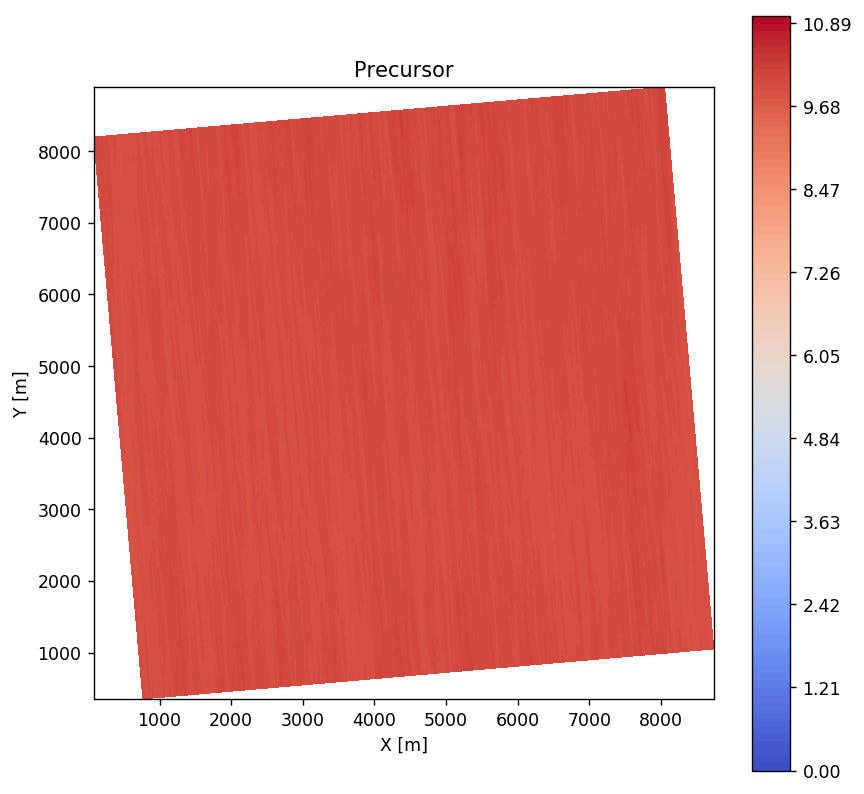

In [14]:
plt.figure(figsize=(8,8), dpi=125)
#plt.contourf(X, Y, Uh_prec, clevels, cmap='coolwarm')
plt.contourf(X, Y, np.sqrt(U_prec**2 + V_prec**2), clevels, cmap='coolwarm')
plt.colorbar()
plt.axis('scaled')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.title('Precursor')

Text(0.5,1,'Turbine')

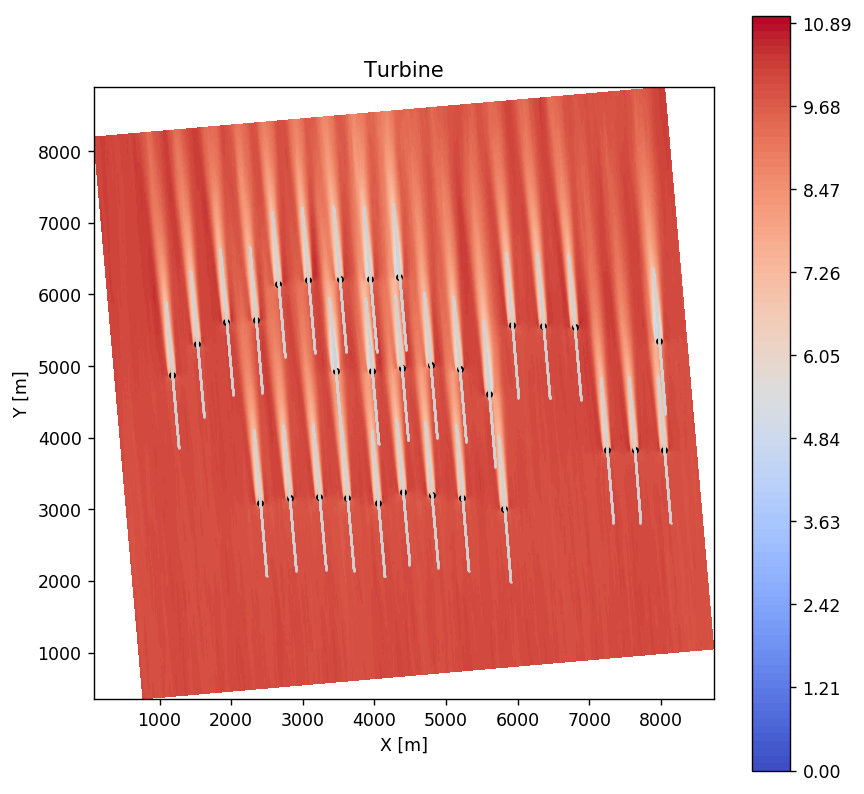

In [19]:
# Build the centerline probe points
CLpts = buildCLpoints(X, Y, U_prec, V_prec, turbxy, dX, Nupstream, Ndownstream)

plt.figure(figsize=(8,8), dpi=125)
plt.contourf(X, Y, Uh_turb, clevels, cmap='coolwarm')
plt.colorbar()
plt.plot(turbxy[:,0], turbxy[:,1], 'k.')
for cl in CLpts:
    plt.plot(cl[:,0], cl[:,1], '.', color='lightgray', ms=1)
plt.axis('scaled')
plt.xlabel('X [m]')
plt.ylabel('Y [m]')
plt.title('Turbine')

In [20]:
# Set up the output YAML file
outputyaml=OrderedDict()
outputyaml['title'] = 'King Plains turbine wake profiles Nalu-Wind'
outputyaml['avgover'] = [tavg1, tavg2]
outputyaml['rotorD']  = rotorD
allwturbfiles=[]
allnoturbfiles=[]

In [21]:
# Write out the results for the wturb cases
CLxvec = np.linspace(-Nupstream*dX, Ndownstream*dX, Nupstream+Ndownstream+1)

for i, cl in enumerate(CLpts[:]):
    CLwind = np.array(getWindVector(X, Y, U_turb, V_turb, cl, W=W_turb, normalize=False))
    savedat = np.zeros((len(CLxvec), 4))
    savedat[:,0] = CLxvec
    savedat[:,1:4] = CLwind
    turbname='T%02i'%i
    filename='/KP_{turb}_CL_wturb.dat'
    savefile=savedir+filename
    savefile=savefile.format(turb=turbname)
    # Create the directory (if needed)
    print(savefile)
    dirpath = os.path.dirname(savefile)
    try:
        os.makedirs(dirpath)
    except:
        pass
    # Save the file
    np.savetxt(savefile, savedat, header=header)
    # Add to the yaml list
    wturbfiles=OrderedDict()
    wturbfiles['name']=turbname
    reldirpath = os.path.relpath(savedir.format(turb=turbname), yamldir)
    wturbfiles['centerline']=reldirpath+filename.format(turb=turbname)
    allwturbfiles.append(wturbfiles)

DATA_SNL_naluwind_stable_KPeast/T00//KP_T00_CL_wturb.dat
DATA_SNL_naluwind_stable_KPeast/T01//KP_T01_CL_wturb.dat
DATA_SNL_naluwind_stable_KPeast/T02//KP_T02_CL_wturb.dat
DATA_SNL_naluwind_stable_KPeast/T03//KP_T03_CL_wturb.dat
DATA_SNL_naluwind_stable_KPeast/T04//KP_T04_CL_wturb.dat
DATA_SNL_naluwind_stable_KPeast/T05//KP_T05_CL_wturb.dat
DATA_SNL_naluwind_stable_KPeast/T06//KP_T06_CL_wturb.dat
DATA_SNL_naluwind_stable_KPeast/T07//KP_T07_CL_wturb.dat
DATA_SNL_naluwind_stable_KPeast/T08//KP_T08_CL_wturb.dat
DATA_SNL_naluwind_stable_KPeast/T09//KP_T09_CL_wturb.dat
DATA_SNL_naluwind_stable_KPeast/T10//KP_T10_CL_wturb.dat
DATA_SNL_naluwind_stable_KPeast/T11//KP_T11_CL_wturb.dat
DATA_SNL_naluwind_stable_KPeast/T12//KP_T12_CL_wturb.dat
DATA_SNL_naluwind_stable_KPeast/T13//KP_T13_CL_wturb.dat
DATA_SNL_naluwind_stable_KPeast/T14//KP_T14_CL_wturb.dat
DATA_SNL_naluwind_stable_KPeast/T15//KP_T15_CL_wturb.dat
DATA_SNL_naluwind_stable_KPeast/T16//KP_T16_CL_wturb.dat
DATA_SNL_naluwind_stable_KPeast

In [22]:
# Write out the results for the wturb cases
CLxvec = np.linspace(-Nupstream*dX, Ndownstream*dX, Nupstream+Ndownstream+1)

for i, cl in enumerate(CLpts[:]):
    CLwind = np.array(getWindVector(X, Y, U_prec, V_prec, cl, W=W_prec, normalize=False))
    savedat = np.zeros((len(CLxvec), 4))
    savedat[:,0] = CLxvec
    savedat[:,1:4] = CLwind
    turbname = 'T%02i'%i
    filename = '/KP_{turb}_CL_noturb.dat'
    savefile = savedir+filename
    savefile = savefile.format(turb=turbname)
    print(savefile)
    # Create the directory (if needed)    
    dirpath = os.path.dirname(savefile)
    try:
        os.makedirs(dirpath)
    except:
        pass
    # Save the file
    np.savetxt(savefile, savedat, header=header)
    # Add to the yaml list
    noturbfiles=OrderedDict()
    noturbfiles['name']=turbname
    reldirpath = os.path.relpath(savedir.format(turb=turbname), yamldir)
    noturbfiles['centerline']=reldirpath+filename.format(turb=turbname)
    allnoturbfiles.append(noturbfiles)

DATA_SNL_naluwind_stable_KPeast/T00//KP_T00_CL_noturb.dat
DATA_SNL_naluwind_stable_KPeast/T01//KP_T01_CL_noturb.dat
DATA_SNL_naluwind_stable_KPeast/T02//KP_T02_CL_noturb.dat
DATA_SNL_naluwind_stable_KPeast/T03//KP_T03_CL_noturb.dat
DATA_SNL_naluwind_stable_KPeast/T04//KP_T04_CL_noturb.dat
DATA_SNL_naluwind_stable_KPeast/T05//KP_T05_CL_noturb.dat
DATA_SNL_naluwind_stable_KPeast/T06//KP_T06_CL_noturb.dat
DATA_SNL_naluwind_stable_KPeast/T07//KP_T07_CL_noturb.dat
DATA_SNL_naluwind_stable_KPeast/T08//KP_T08_CL_noturb.dat
DATA_SNL_naluwind_stable_KPeast/T09//KP_T09_CL_noturb.dat
DATA_SNL_naluwind_stable_KPeast/T10//KP_T10_CL_noturb.dat
DATA_SNL_naluwind_stable_KPeast/T11//KP_T11_CL_noturb.dat
DATA_SNL_naluwind_stable_KPeast/T12//KP_T12_CL_noturb.dat
DATA_SNL_naluwind_stable_KPeast/T13//KP_T13_CL_noturb.dat
DATA_SNL_naluwind_stable_KPeast/T14//KP_T14_CL_noturb.dat
DATA_SNL_naluwind_stable_KPeast/T15//KP_T15_CL_noturb.dat
DATA_SNL_naluwind_stable_KPeast/T16//KP_T16_CL_noturb.dat
DATA_SNL_naluw

In [23]:
# write out the yaml file
outputyaml['turbinerun']=allwturbfiles
outputyaml['precursorrun']=allnoturbfiles

# Go to the data directory
cwd              = os.getcwd()
if not os.path.exists(yamldir):
    os.makedirs(yamldir)
os.chdir(yamldir)

with open(yamlfile, 'w') as f:
    yaml.dump(outputyaml, f, **dumperkwargs)
    
# Go back to the original directory
os.chdir(cwd)